# Quantização

Neste notebook, investigamos de maneira aproximada os fenômenos de aproximação associados ao processo de quantização.

In [1]:
# importar as bibliotecas necessárias
import numpy as np # arrays
import matplotlib.pyplot as plt # plots
import scipy
plt.rcParams.update({'font.size': 14})
import IPython.display as ipd # to play signals
import sounddevice as sd

## Criar um sinal senoidal (com órtima resolução de escala)

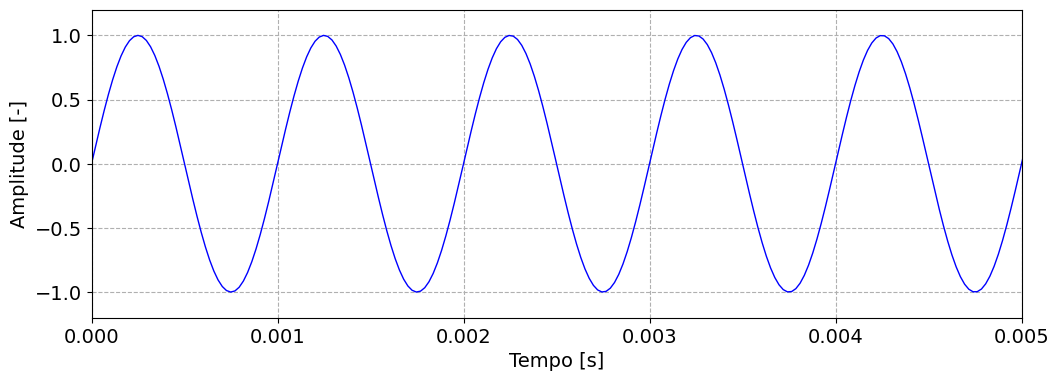

In [10]:
fs = 44100
time = np.arange(0, 2, 1/fs)

xt = 1*np.sin(2*np.pi*1000*time)

plt.figure(figsize = (12, 4))
plt.plot(time, xt, '-b', linewidth = 1)
plt.grid(linestyle = '--', which='both')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude [-]')
plt.xlim((0, 0.005))
plt.ylim((-1.2, 1.2))

ipd.Audio(xt, rate=fs) # load a NumPy array

## Vamos quantizar o nosso seno

Escolhemos

- n_bits : número de bits no processo de quantização
- max_level : máximo nível $\pm$ suportado pela eletrônica da placa de som

bins representará um vetor de possibilidades para alocação das amplitudes

In [28]:
n_bits = 4
max_level = 2 # Vamos assumir que isso seja em Volt
bins = np.linspace(-max_level, max_level, 2**n_bits)
print("Amplitude resolution {:.6f} [mV]".format(1000*(bins[1]-bins[0])))

Amplitude resolution 266.666667 [mV]


## Usamos a função np.digitize

Ela retorna um array com os índices em bins de cada amostra do sinal. Basicamente ela nos diz pra que valor cada amostra do sinal é quantizada.

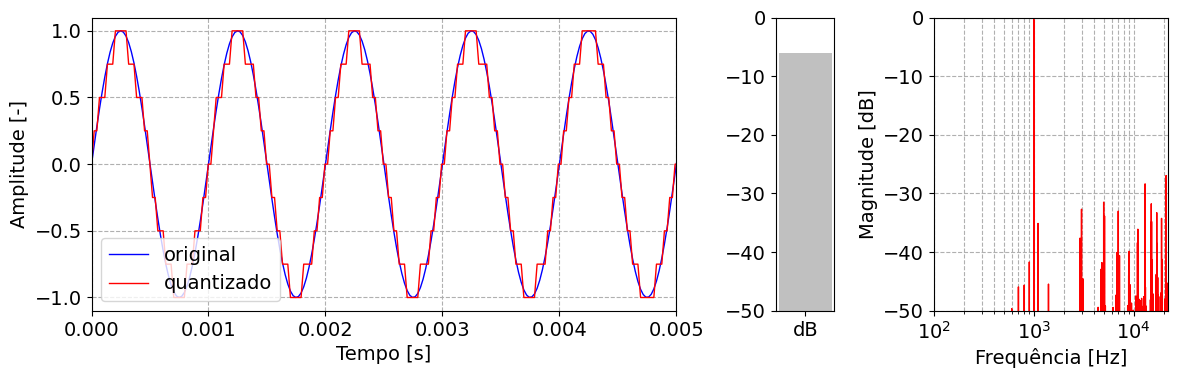

In [29]:
# Use np.digitize
idx = np.digitize(xt, bins)
xt_qtz = max_level*(2*idx/(2**n_bits)-1)

Xw_qtz = np.fft.fft(xt_qtz)
Xw_qtz[Xw_qtz==0] = np.finfo(float).eps 
freq = np.linspace(0, (len(xt_qtz)-1)*fs/len(xt_qtz), len(xt_qtz))

fig, axs = plt.subplots(1, 3, gridspec_kw={'width_ratios': [10, 1, 4]}, figsize = (12, 4))
axs[0].plot(time, xt, '-b', linewidth = 1, label = 'original')
axs[0].plot(time, xt_qtz, '-r', linewidth = 1, label = 'quantizado')
axs[0].legend(loc = 'lower left')
axs[0].grid(linestyle = '--', which='both')
axs[0].set_xlabel('Tempo [s]')
axs[0].set_ylabel('Amplitude [-]')
axs[0].set_xlim((0, 0.005))
#axs[0].set_ylim((-max_level, max_level))

axs[1].bar('dB', 50+20*np.log10(1/max_level), bottom = -50, color = 'silver')
axs[1].set_ylim((-50, 0))
axs[1].set_ylim((-50, 0))

axs[2].semilogx(freq, 20*np.log10(2*np.abs(Xw_qtz)/(len(xt_qtz))), '-r', linewidth = 1, label = 'spk quantizado')
#axs[2].semilogx(freq, 2*np.abs(Xw_qtz)/(len(xt_qtz)), '-r', linewidth = 1, label = 'spk quantizado')
axs[2].grid(linestyle = '--', which='both')
axs[2].set_xlabel('Frequência [Hz]')
axs[2].set_ylabel('Magnitude [dB]')
axs[2].set_xlim((100, fs/2))
axs[2].set_ylim((-50, 0))
plt.tight_layout()

ipd.Audio(xt_qtz, rate=fs) # load a NumPy array

# Com um sweep

In [47]:
#### Sweep  ######################
Fs = 44100
time = np.arange(0, 5, 1/Fs)
xt = 1.3*scipy.signal.chirp(time, 250, time[-1], 16000, method='logarithmic') #'logarithmic'

In [48]:
ipd.Audio(xt, rate=Fs) # load a NumPy array

In [42]:
n_bits = 24
max_level = 1 # Vamos assumir que isso seja em Volt
bins = np.linspace(-max_level, max_level, 2**n_bits)
print("Amplitude resolution {:.4f} [mV]".format(1000*(bins[1]-bins[0])))

Amplitude resolution 0.0001 [mV]


In [43]:
# Use np.digitize
idx = np.digitize(xt, bins)
xt_qtz = max_level*(2*idx/(2**n_bits)-1)
ipd.Audio(xt_qtz, rate=Fs) # load a NumPy array

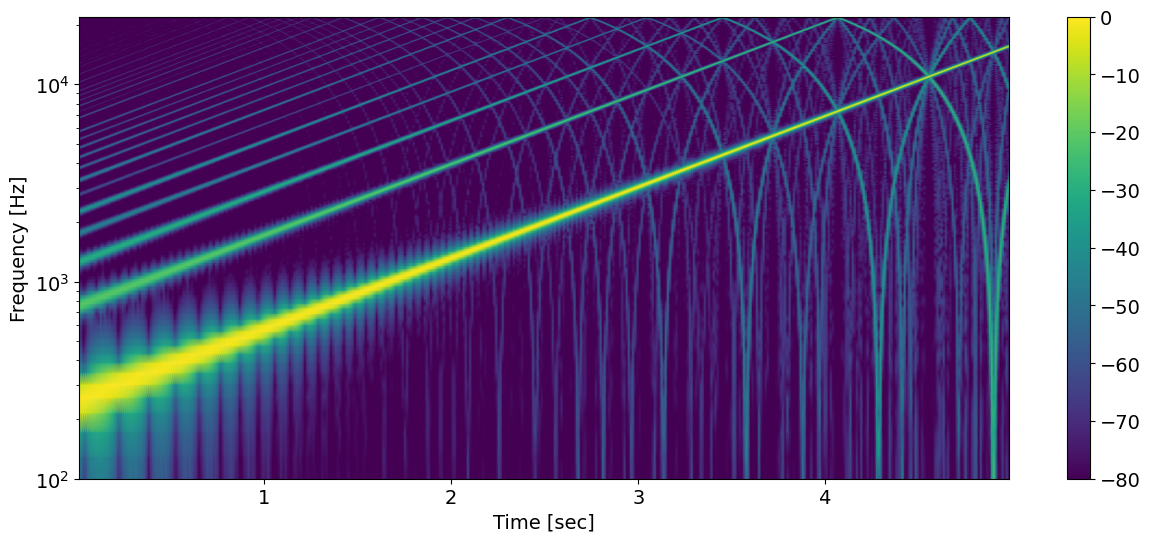

In [46]:
win = scipy.signal.windows.hann(1024)
f, t, Sxx = scipy.signal.spectrogram(xt_qtz, Fs, window = win, noverlap = len(win)/2, scaling = 'spectrum')

plt.figure(figsize=(15,6))
p = plt.pcolormesh(t, f, 10*np.log10(Sxx/np.amax(Sxx)), shading='gouraud', vmin = -80, cmap = 'viridis')
plt.colorbar(p)
plt.ylim((100, Fs/2))
plt.yscale('log')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()


Text(0, 0.5, 'Amplitude [-]')

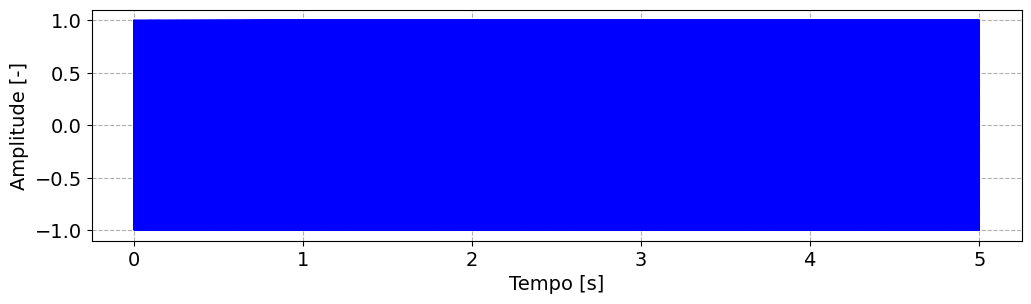

In [45]:
Delta_t =0

plt.figure(figsize=(12,3))
plt.plot(time, xt_qtz, '-b', linewidth = 1)
plt.grid(linestyle = '--', which='both')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude [-]')
#plt.xlim((0+Delta_t, Delta_t+0.1));